# Monitoramento de casos de CVID19 no Brasil.

**Este notebook tem como objetivo aplicar técnicas de análise da dados, somente para fins didáticos.**

### INFORMAÇÕES SOBRE AS BASES UTILIZADAS

* Base utilizada para extrair dados do Brasil e Estados [G1  Globo](https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/27/casos-de-coronavirus-no-brasil-em-27-de-marco.ghtml) Fonte: Ministério da Saúde até 15 de março; secretarias estaduais da Saúde a partir de 16 de março.Criado com Datawrapper

* Base utilizada para extrair dados dos Municipios [brasil.io](https://brasil.io/dataset/covid19/caso) Boletins informativos baseado no Ministério da Saúde e secretarias estaduais da Saúde.

* Base utilizada para extrair dados dos Mundial  [BNO News]( https://bnonews.com/index.php/2020/03/the-latest-coronavirus-cases ) Boletins informativos baseado nos dados da OMS.

* Base utilizada para extrair dados dos Mundial [OMS]( https://who.sprinklr.com)OMS.

* Base utilizada para extrair dados dos Estados [Ministério da Saúde]( https://covid.saude.gov.br/ )

*Nenhuma copia deste notebook é permitida sem citar a fonte original.*

In [1]:
#!pip install dash

In [2]:
import pandas as pd
import numpy as np
import cufflinks as cf
import wget
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import matplotlib.pyplot as plt
import folium
import os
import requests
import json
from pandas.io.json import json_normalize
from folium import plugins
from numpy import nan as NA
from plotly.offline import iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
cf.go_offline()
plotly.offline.init_notebook_mode(connected=True)

## Carregamento e Tratamento dos Dados

In [4]:

################################downloads######################################################### 
url_brasil_io = 'https://brasil.io/dataset/covid19/caso?format=csv'
if os.path.exists('DB/api_br_io.csv'):
    os.remove('DB/api_br_io.csv')
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
else:
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
################################################################################################### 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/dfe64e164c58c05c77afdd5ecbe8c689_Download_COVID19_20200413.csv')
if os.path.exists('DB/ministerio_saude.csv'):
    os.remove('DB/ministerio_saude.csv')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
###############################read_csv######################################################### 
estados = pd.read_csv('DB/estados.csv', encoding='utf-8')
municipios = pd.read_csv('DB/municipios.csv', encoding='utf-8')
api_br_io = pd.read_csv('DB/api_br_io.csv')
api_br_io = api_br_io.fillna(0)
api_br_io.city_ibge_code = api_br_io.city_ibge_code.astype('int64')
url_estados = 'DB/estados.json'
cidades = pd.read_json(url_estados)
municipios_map = json_normalize(cidades.features)  
casos = pd.read_csv('DB/ministerio_saude.csv', sep=';', encoding='cp1252')

########################################################################
#renomeando colunas
municipios.columns = ['city_ibge_code','city','latitude','longitude','capital','uf_code']
casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']

#tratando nomes para fazer o merge
estados = estados[['uf', 'nome']]
estados.columns = ['state','state_name']
cidades = api_br_io.merge(municipios.drop('uf_code', axis=1), on=['city','city_ibge_code'], how='left')
cidades = cidades.merge(estados, on='state', how='left')

cidades = cidades[(cidades.is_last==True) & (cidades.city !='Importados/Indefinidos')]
dados = cidades[ cidades.latitude.notnull() ]
cidades = dados[dados.place_type == 'city']
saude = pd.DataFrame(casos)

100% [..............................................................................] 64630 / 64630

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



### Criando dados gerais do Brasil

In [5]:
dados = saude.copy()
#dados['data'] = pd.to_datetime(dadosGeral['data'])

casosTotal = dados['casosAcumulados'].groupby(dados['data']).sum().sort_values(ascending=True)
casosTotal = casosTotal[casosTotal>=0].reset_index().drop('data',axis=1)

mortesTotal = dados['obitosAcumulados'].groupby(dados['data']).sum().sort_values(ascending=True)
mortesTotal = mortesTotal[mortesTotal>=0].reset_index().drop('data',axis=1)


# Gráficos Brasil

In [6]:
fig = go.Figure(
    [
        go.Scatter(x = dados.data, y = casosTotal['casosAcumulados'], mode = 'markers+lines', name="Casos acumulados"),
        go.Scatter(x = dados.data, y = mortesTotal['obitosAcumulados'], mode = 'markers+lines', name="Óbitos acumulados"),
    ]
)


fig.update_layout(title='Confirmados Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white")

fig.show()

plotly.offline.plot(fig, filename='HTML/AcumuladoBrasilDia.html', auto_open=False)

'HTML/AcumuladoBrasilDia.html'

In [7]:
fig = px.line(dados, x='data', y='casosAcumulados',color="sigla",line_group="sigla", hover_name="sigla" , text='obitosAcumulados')
fig.update_layout(title='Casos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/CasosAcumuladoEstadosDia.html', auto_open=False)

'HTML/CasosAcumuladoEstadosDia.html'

In [8]:

fig = px.line(dados, x='data', y='obitosAcumulados',color="sigla",line_group="sigla", hover_name="sigla", text='obitosAcumulados')
fig.update_layout(title='Óbitos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/ObitosAcumuladoEstadosDia.html', auto_open=False)

'HTML/ObitosAcumuladoEstadosDia.html'

In [9]:

trace = go.Pie(labels = list(dados.regiao),
               values = list(dados.casosNovos),
               textinfo='percent+value'
              )

# Armazenando gráfico em uma lista:
casos = [trace]

# Criando Layout:
layout = go.Layout(title='Porcentagem de casos confirmados por Região')

# Criando figura que será exibida:
fig = go.Figure(data=casos, layout=layout)

py.iplot(fig)
plotly.offline.plot(fig, filename='HTML/PercentualAcumuladoRegiaoDia.html', auto_open=False)

'HTML/PercentualAcumuladoRegiaoDia.html'

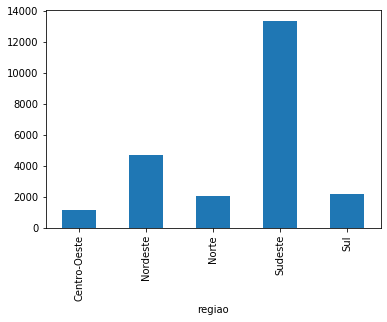

In [10]:
regiao =dados.groupby('regiao')
soma= regiao.casosNovos.sum()
soma.plot(kind='bar')



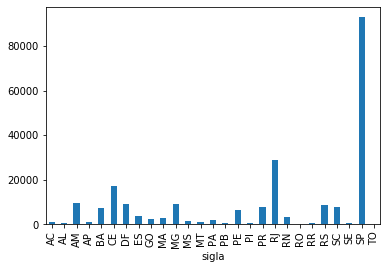

In [11]:
estados =dados.groupby('sigla')
acumuladodia= estados.casosAcumulados.sum()
acumuladodia.plot(kind='bar')

In [12]:
#api_br_io[ (api_br_io.state == 'RS')]

In [60]:
dataRS =api_br_io[ api_br_io.city.notnull() ]
rs = dataRS [ (dataRS.state == 'RS')&(dataRS.date == '2020-04-13') & (dataRS.place_type =='city')].sort_values(by='confirmed',ascending=False)
rs.groupby(['city'] )
rs.fillna(0, inplace = True)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Cidades  % '+ str(round(rs.city.size*100/497,2)) +'<br><b>Total--</b>'+str(rs.city.size) +'</br>' ,
                        '<br>Confirmados</br> <b>Total-</b>'+ str(rs.confirmed.sum()),
                        '<br>Mortes</br>  <b>Total-</b>'+ str(rs.deaths.sum().astype(int))],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[rs.city, rs.confirmed,rs.deaths],
               fill_color='lavender',
               align='left'))
])

fig.show()
plotly.offline.plot(fig, filename='HTML/TabelaCovid19RS.html', auto_open=False)

'HTML/TabelaCovid19RS.html'

In [61]:
#![Tabela1 casos confirmados por cidades do RS](IMG/Alegrete.jpg)

In [62]:
import plotly.express as px


fig = px.bar(rs.head(10), y='city', x='confirmed',color='deaths', text='confirmed',orientation='h')

fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [63]:
#![Figura4 Acumulado dos casos no RS e óbitos](IMG/RS.jpg)

In [64]:
br_estados = 'DB/br_states.json'
geo_json_data = json.load(open(br_estados))
covid= cidades.copy()
df_bsb =covid[( covid.city.notnull()) & (covid.place_type =='city') ]

In [65]:
from folium.plugins import MarkerCluster

In [66]:
#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(
    location=[-15.77972, -47.92972],    # Coordenadas retiradas do Google Maps / Longitude ajustada
    zoom_start=4
)

for _, dados in df_bsb.iterrows():
    folium.Circle(
        location=[dados['latitude'], dados['longitude']], clustered_marker = True,
        popup= dados.city  +'<br><b>Data--</b>'+str(dados.date) +'<br><b>Casos--</b>'+str(dados.confirmed) +'</br>'+'<br><b>Óbitos--</b>'+str(dados.deaths) +'</br>'+'<br><b>Taxa de Mortalidade--</b>'+str(dados.death_rate) +'</br>',
         radius=dados['confirmed']*100,
        color='crimson',
        fill=True,
        fill_color='crimson'

    ).add_to(brasil)

brasil

In [67]:
#![Figura5 casos no Brasil por dia](IMG/BrasilCasosDITRI.jpg)

In [72]:
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'green',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
brasil.save('HTML/MapaBrasilCovid19.html')


In [69]:
#![Figura6 casos no RS ](IMG/RScasosDISTRI.jpg)

In [70]:
from datetime import datetime
now = datetime.now()

In [71]:
#hack ministério da saéde
print (str(now.year)+str(now.month)+str(now.day))


2020414
